In [1]:
###fMRI decoding: using event signals instead of activation pattern from glm
##collect task-fMRI signals
from pathlib import Path
pathroot=Path('/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/')
subject = 'sub01'
modality = 'motor'

pathdata = pathroot/subject/modality
print(pathdata)

import glob
fmri_files = [];
confound_files = [];
EVS_files = [];
for file in sorted(pathdata.glob('sess*/run*/filtered_func_data_ICA.nii.gz')):
    fmri_files.append(str(file))

for confound in sorted(pathdata.glob('sess*/run*/filtered_func_data_mcf.1D')):
    confound_files.append(str(confound))

for ev in sorted(pathdata.glob('sess*/run*/motor_events.txt')):
    EVS_files.append(str(ev))
    
print(fmri_files)
print(confound_files)
print(EVS_files)

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor
['/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run2/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run2/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run2/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run2/filtered_func_data_ICA.nii.gz', '/data/ci

In [2]:
##loading fMRI signals using atlas
import numpy as np
from nilearn.image import mean_img
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker
TR = 2.2
mist_atlas_file = "/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"

subjects_tc_matrix = [];
for fmri_file,confound_file in zip(fmri_files,confound_files):
    #fmri_file = fmri_files[0]
    #confound_file = confound_files[0]
    brain_masker = NiftiMasker(mask_strategy='epi')
    brain_masker.fit_transform(fmri_file)
    mean_fmri = mean_img(fmri_file)
    ##adjust group atlas to individual brain mask
    mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,mask_img=brain_masker.mask_img_,
                                  detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
    ##standardize:time-series are centered and normed: their mean is put to 0 and their variance to 1 in the time dimension.
    mist_roi_tc = mist_atlas.fit_transform(fmri_file,confounds=confound_file)
    subjects_tc_matrix.append(mist_roi_tc)

print(np.array(subjects_tc_matrix).shape)

(20, 104, 210)


In [3]:
###combining multiple sessions together
import pandas as pd
Subject_Num = len(subjects_tc_matrix)
Trial_Num = len(subjects_tc_matrix[0])
print("Data samples including %d subjects with %d trials for each" % (Subject_Num, Trial_Num))

###dict for different types of movement
task_contrasts = {"RFoot": "foot",
                  "LFoot": "foot",
                  "RHand": "hand",
                  "LHand": "hand",
                  "Tongue": "tongue"}

subjects_trial_label_matrix = []
for subj in np.arange(Subject_Num):
    ##trial info in volume
    trial_infos = pd.read_csv(EVS_files[0], sep="\t",encoding="utf8")
    Onsets = np.ceil((trial_infos.onset/TR)).astype(int) #(trial_infos.onset/TR).astype(int)
    Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)
    Movetypes = trial_infos.trial_type
    
    labels = ["rest"]*Trial_Num;
    for start,dur,move in zip(Onsets,Duras,Movetypes):
        for ti in range(start-1,start+dur):
            labels[ti]= task_contrasts[move]
    subjects_trial_label_matrix.append(labels)

print(np.array(subjects_tc_matrix).shape)
print(np.array(subjects_trial_label_matrix).shape)

Data samples including 20 subjects with 104 trials for each
(20, 104, 210)
(20, 104)


(2080, 210) (2080,)
Accuracy of prediction with SVM-RBF kernel: 0.902703
SVM Scoring:
[ 0.40540541  0.43918919  0.38513514  0.43918919  0.39864865  0.4527027
  0.39864865  0.39864865  0.50675676  0.4527027 ]
Accuracy of prediction with SVM-linear kernel: 0.816892
SVM Scoring:
[ 0.37837838  0.38513514  0.42567568  0.41891892  0.37837838  0.29054054
  0.49324324  0.35810811  0.36486486  0.58108108]
(61, 73, 61, 3)


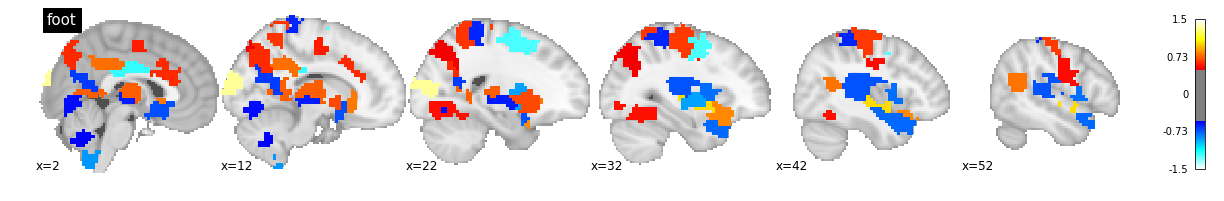

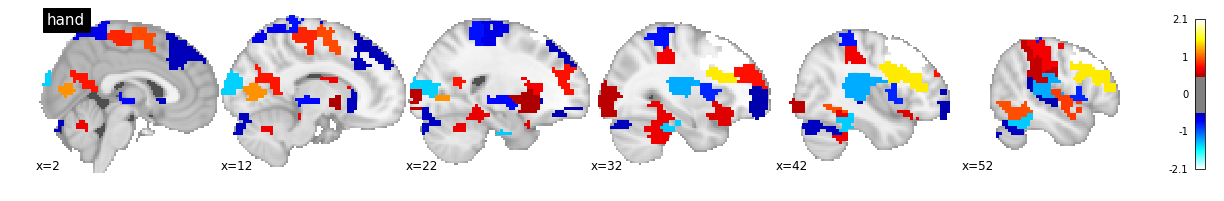

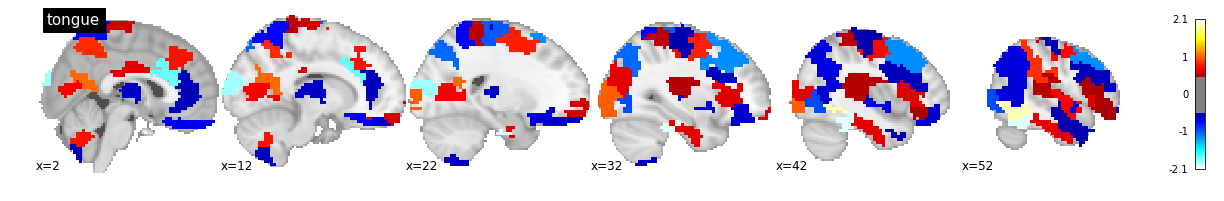

In [4]:
###SVM classifier
##feature matrix
fmri_data = np.vstack(subjects_tc_matrix)
label_data = np.vstack(subjects_trial_label_matrix).reshape(Subject_Num*Trial_Num,)
print(fmri_data.shape,label_data.shape)

condition_mask = pd.Series(label_data).isin(np.unique(list(task_contrasts.values())))
X_data = fmri_data[condition_mask,]
Y_data = label_data[condition_mask]

##build a simple classifier using SVM
from sklearn import svm,metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_data_scaled = X_data #preprocessing.scale(X_data) #with zero mean and unit variance.
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_data_scaled,Y_data)
acc_score = metrics.accuracy_score(clf.predict(X_data_scaled),Y_data)
print("Accuracy of prediction with SVM-RBF kernel: %4f" % acc_score)

my_cv_fold = 10
clf = svm.SVC(decision_function_shape='ovo')
scores = cross_val_score(clf, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
print('SVM Scoring:')
print(scores)

####to show the coefficients
clf_lin = svm.SVC(decision_function_shape='ovr',kernel='linear')
clf_lin.fit(X_data_scaled,Y_data)
acc_score = metrics.accuracy_score(clf_lin.predict(X_data_scaled),Y_data)
print("Accuracy of prediction with SVM-linear kernel: %4f" % acc_score)
scores_lin = cross_val_score(clf_lin, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
print('SVM Scoring:')
print(scores_lin)
#print(clf_lin.support_vectors_.shape)
#print(clf_lin.n_support_ )

mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
mist_atlas.fit_transform(fmri_file,confounds=confound_file)
roi_coefs = clf_lin.coef_
svc_coef_img = mist_atlas.inverse_transform(roi_coefs)
print(svc_coef_img.shape)
##svc_coef_img.to_filename('fmri_decoding_motor_svc_weights.nii.gz')

import matplotlib.pyplot as plt
%matplotlib inline
from nilearn import plotting,image
target_name=np.unique(list(task_contrasts.values()))
ii = 0;
for img in image.iter_img(svc_coef_img):
    plotting.plot_stat_map(img,display_mode="x",cut_coords=range(2, 53, 10),threshold=0.5,title=target_name[ii])
    ii += 1

In [8]:
###prepare the data samples
import numpy as np
from keras.utils import np_utils

##feature matrix
fmri_data = np.vstack(subjects_tc_matrix)
label_data = np.vstack(subjects_trial_label_matrix).reshape(Subject_Num*Trial_Num,)
target_name=np.unique(list(task_contrasts.values()))  ##np.unique(label_data)  ##whether to exclude 'rest'
condition_mask = pd.Series(label_data).isin(target_name)
X_data = fmri_data[condition_mask,]
Y_data = label_data[condition_mask]

from sklearn import preprocessing
X_data_scaled = preprocessing.scale(X_data) #with zero mean and unit variance.
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_data_int = le.transform(Y_data)
Y_data_label = np_utils.to_categorical(Y_data_int)

print(target_name)
print(X_data_scaled.shape,Y_data_label.shape)

['foot' 'hand' 'tongue']
(1480, 210) (1480, 3)


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(model_history):
    plt.figure()
    plt.subplot(121)
    plt.plot(model_history.history['acc'],color='r')
    plt.plot(model_history.history['val_acc'], color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training','Validation'])
    
    plt.subplot(122)
    plt.plot(model_history.history['loss'],color='r')
    plt.plot(model_history.history['val_loss'],color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Function')
    plt.legend(['Training','Validation'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 210)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                13504     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 192)               24768     
_________________________________________________________________
dropout_8 (Dropout)          (None, 192)               0         
__________

Epoch 46/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.5405 - acc: 0.7874 - val_loss: 0.6466 - val_acc: 0.7761
Epoch 47/500
1265/1265 [==============================] - 0s 21us/step - loss: 0.5341 - acc: 0.7660 - val_loss: 0.6439 - val_acc: 0.7910
Epoch 48/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.5335 - acc: 0.7802 - val_loss: 0.6311 - val_acc: 0.8060
Epoch 49/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.4955 - acc: 0.8103 - val_loss: 0.6099 - val_acc: 0.8209
Epoch 50/500
1265/1265 [==============================] - 0s 15us/step - loss: 0.4821 - acc: 0.8079 - val_loss: 0.5805 - val_acc: 0.8209
Epoch 51/500
1265/1265 [==============================] - 0s 16us/step - loss: 0.4617 - acc: 0.8087 - val_loss: 0.5643 - val_acc: 0.8209
Epoch 52/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.4909 - acc: 0.8111 - val_loss: 0.5564 - val_acc: 0.8507
Epoch 53/500
1265/1265 [=================

Epoch 106/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.1206 - acc: 0.9589 - val_loss: 0.4819 - val_acc: 0.8657
Epoch 107/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.1371 - acc: 0.9542 - val_loss: 0.4862 - val_acc: 0.8955
Epoch 108/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.1356 - acc: 0.9549 - val_loss: 0.4873 - val_acc: 0.8955
Epoch 109/500
1265/1265 [==============================] - 0s 17us/step - loss: 0.1142 - acc: 0.9597 - val_loss: 0.4867 - val_acc: 0.8657
Epoch 110/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.1517 - acc: 0.9510 - val_loss: 0.5142 - val_acc: 0.8657
Epoch 111/500
1265/1265 [==============================] - 0s 17us/step - loss: 0.1333 - acc: 0.9526 - val_loss: 0.5150 - val_acc: 0.8657
Epoch 112/500
1265/1265 [==============================] - 0s 15us/step - loss: 0.1261 - acc: 0.9486 - val_loss: 0.4984 - val_acc: 0.8806
Epoch 113/500
1265/1265 [=========

1265/1265 [==============================] - 0s 13us/step - loss: 0.0755 - acc: 0.9810 - val_loss: 0.4937 - val_acc: 0.8806
Epoch 166/500
1265/1265 [==============================] - 0s 14us/step - loss: 0.0729 - acc: 0.9755 - val_loss: 0.4821 - val_acc: 0.8806
Epoch 167/500
1265/1265 [==============================] - 0s 14us/step - loss: 0.0873 - acc: 0.9715 - val_loss: 0.4878 - val_acc: 0.8806
Epoch 168/500
1265/1265 [==============================] - 0s 13us/step - loss: 0.0733 - acc: 0.9771 - val_loss: 0.5085 - val_acc: 0.8806
Epoch 169/500
1265/1265 [==============================] - 0s 16us/step - loss: 0.0550 - acc: 0.9826 - val_loss: 0.5308 - val_acc: 0.8806
Epoch 170/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0698 - acc: 0.9802 - val_loss: 0.5439 - val_acc: 0.8806
Epoch 171/500
1265/1265 [==============================] - 0s 17us/step - loss: 0.0722 - acc: 0.9731 - val_loss: 0.5242 - val_acc: 0.8955
Epoch 172/500
1265/1265 [=======================

1265/1265 [==============================] - 0s 18us/step - loss: 0.0580 - acc: 0.9802 - val_loss: 0.6183 - val_acc: 0.8955
Epoch 225/500
1265/1265 [==============================] - 0s 21us/step - loss: 0.0548 - acc: 0.9842 - val_loss: 0.5789 - val_acc: 0.8955
Epoch 226/500
1265/1265 [==============================] - 0s 21us/step - loss: 0.0448 - acc: 0.9858 - val_loss: 0.5506 - val_acc: 0.8955
Epoch 227/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.0482 - acc: 0.9818 - val_loss: 0.5592 - val_acc: 0.9104
Epoch 228/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0718 - acc: 0.9834 - val_loss: 0.5739 - val_acc: 0.8955
Epoch 229/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.0487 - acc: 0.9850 - val_loss: 0.5672 - val_acc: 0.8955
Epoch 230/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0403 - acc: 0.9866 - val_loss: 0.5482 - val_acc: 0.8955
Epoch 231/500
1265/1265 [=======================

1265/1265 [==============================] - 0s 16us/step - loss: 0.0481 - acc: 0.9826 - val_loss: 0.5424 - val_acc: 0.8955
Epoch 284/500
1265/1265 [==============================] - 0s 14us/step - loss: 0.0489 - acc: 0.9881 - val_loss: 0.5285 - val_acc: 0.8955
Epoch 285/500
1265/1265 [==============================] - 0s 13us/step - loss: 0.0431 - acc: 0.9858 - val_loss: 0.5507 - val_acc: 0.9104
Epoch 286/500
1265/1265 [==============================] - 0s 14us/step - loss: 0.0290 - acc: 0.9881 - val_loss: 0.5966 - val_acc: 0.9104
Epoch 287/500
1265/1265 [==============================] - 0s 15us/step - loss: 0.0209 - acc: 0.9929 - val_loss: 0.6214 - val_acc: 0.9104
Epoch 288/500
1265/1265 [==============================] - 0s 12us/step - loss: 0.0395 - acc: 0.9842 - val_loss: 0.6399 - val_acc: 0.9104
Epoch 289/500
1265/1265 [==============================] - 0s 12us/step - loss: 0.0258 - acc: 0.9905 - val_loss: 0.6578 - val_acc: 0.9104
Epoch 290/500
1265/1265 [=======================

1265/1265 [==============================] - 0s 20us/step - loss: 0.0360 - acc: 0.9874 - val_loss: 0.6098 - val_acc: 0.8806
Epoch 343/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.0312 - acc: 0.9889 - val_loss: 0.6006 - val_acc: 0.8955
Epoch 344/500
1265/1265 [==============================] - 0s 22us/step - loss: 0.0245 - acc: 0.9953 - val_loss: 0.6006 - val_acc: 0.8955
Epoch 345/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.0259 - acc: 0.9913 - val_loss: 0.6293 - val_acc: 0.8806
Epoch 346/500
1265/1265 [==============================] - 0s 16us/step - loss: 0.0183 - acc: 0.9937 - val_loss: 0.6641 - val_acc: 0.8806
Epoch 347/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0387 - acc: 0.9866 - val_loss: 0.6699 - val_acc: 0.8806
Epoch 348/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.0448 - acc: 0.9889 - val_loss: 0.6725 - val_acc: 0.8806
Epoch 349/500
1265/1265 [=======================

1265/1265 [==============================] - 0s 17us/step - loss: 0.0387 - acc: 0.9889 - val_loss: 0.8744 - val_acc: 0.8507
Epoch 402/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0365 - acc: 0.9889 - val_loss: 0.8233 - val_acc: 0.8657
Epoch 403/500
1265/1265 [==============================] - 0s 19us/step - loss: 0.0340 - acc: 0.9913 - val_loss: 0.7594 - val_acc: 0.8657
Epoch 404/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0268 - acc: 0.9905 - val_loss: 0.7319 - val_acc: 0.8657
Epoch 405/500
1265/1265 [==============================] - 0s 15us/step - loss: 0.0250 - acc: 0.9921 - val_loss: 0.7521 - val_acc: 0.8657
Epoch 406/500
1265/1265 [==============================] - 0s 15us/step - loss: 0.0250 - acc: 0.9921 - val_loss: 0.7652 - val_acc: 0.8507
Epoch 407/500
1265/1265 [==============================] - 0s 15us/step - loss: 0.0365 - acc: 0.9889 - val_loss: 0.7832 - val_acc: 0.8657
Epoch 408/500
1265/1265 [=======================

1265/1265 [==============================] - 0s 21us/step - loss: 0.0192 - acc: 0.9929 - val_loss: 0.7460 - val_acc: 0.8507
Epoch 461/500
1265/1265 [==============================] - 0s 21us/step - loss: 0.0185 - acc: 0.9929 - val_loss: 0.7481 - val_acc: 0.8507
Epoch 462/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0298 - acc: 0.9905 - val_loss: 0.7000 - val_acc: 0.8657
Epoch 463/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0217 - acc: 0.9921 - val_loss: 0.6608 - val_acc: 0.8806
Epoch 464/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0339 - acc: 0.9913 - val_loss: 0.6428 - val_acc: 0.8657
Epoch 465/500
1265/1265 [==============================] - 0s 18us/step - loss: 0.0249 - acc: 0.9929 - val_loss: 0.6741 - val_acc: 0.8507
Epoch 466/500
1265/1265 [==============================] - 0s 17us/step - loss: 0.0247 - acc: 0.9913 - val_loss: 0.7404 - val_acc: 0.8358
Epoch 467/500
1265/1265 [=======================

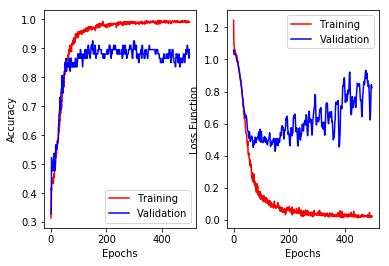

In [10]:
######fully-connected neural networks
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model

Nfeatures = X_data_scaled.shape[1]   
layers = 4
hidden_size = 64
input0 = Input(shape=(Nfeatures,))
drop1 = input0 
for li in np.arange(layers):
    hidden1 = Dense(hidden_size*(li+1),activation='relu')(drop1)
    drop1 = Dropout(0.25)(hidden1)

hidden2 = Dense(128,activation='relu')(drop1)
drop2 = Dropout(0.5)(hidden2)
out = Dense(len(target_name), activation='softmax')(drop2)

model = Model(inputs=input0,outputs=out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

####running the model
import time
start_time = time.clock()

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X_data_scaled, Y_data_label,test_size=0.1, random_state=10)
print('Samples for training: %d and testing %d with %d features' % (X_train.shape[0],X_test.shape[0],X_train.shape[1]))

model_history = model.fit(X_train,Y_train,batch_size=512,epochs=500,validation_split=0.05)
plot_history(model_history)
print('Time Usage in seconds: {}'.format(time.clock()-start_time))

test_loss,test_acc = model.evaluate(X_test,Y_test)
print('Testing sets: Loss: %4f and Accuracy: %4f' % (test_loss,test_acc))

In [12]:
##find out the gpu usage
# Creates a graph.
import tensorflow as tf
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))


[[ 22.  28.]
 [ 49.  64.]]


In [13]:
###graph cnn model
%matplotlib inline
%run -i '/data/cisl/raw_data/midnight/Rawdata/nii_data/codes/keras-gcn-master/kegra/layers/graph.py'
%run -i '/data/cisl/raw_data/midnight/Rawdata/nii_data/codes/keras-gcn-master/kegra/utils.py'

[[1 1 1 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]]


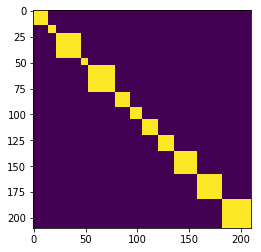

In [14]:
###combining multiple sessions together
import pandas as pd
import numpy as np
hierarchy_file = "/data/cisl/raw_data/midnight/MIST_atlas/Hierarchy/MIST_PARCEL_ORDER_ROI.csv"
df1 = pd.read_csv(hierarchy_file, sep=',', encoding="utf8",  error_bad_lines=False)
network_info = df1.s12
region_order = df1.sROI
RegionsNum = len(np.unique(region_order))
unique_assign = df1.groupby(['s12','sROI']).size().reset_index().rename(columns={0:'count'})

affinity_matrix = np.zeros((RegionsNum,RegionsNum), dtype=int)
for ci in np.unique(unique_assign.s12):
    x = (unique_assign.s12==ci).astype(int)
    affinity_matrix += np.multiply.outer(x, x)
print(affinity_matrix)
plt.imshow(affinity_matrix)

In [15]:
def get_splits(y):
    Nsamples = len(y)
    print('%d samples in total' % Nsamples)
    print('spliting data samples into training,validating, and testing...')
    trainNum = np.round(Nsamples*0.6).astype(int)
    valNum = np.round(Nsamples*0.1).astype(int)
    testNum = np.round(Nsamples*0.3).astype(int)
    idx_train = range(trainNum)
    idx_val = range(trainNum, trainNum+valNum)
    idx_test = range(trainNum+valNum, Nsamples)
    y_train = np.zeros(y.shape, dtype=np.int32)
    y_val = np.zeros(y.shape, dtype=np.int32)
    y_test = np.zeros(y.shape, dtype=np.int32)
    y_train[idx_train] = y[idx_train]
    y_val[idx_val] = y[idx_val]
    y_test[idx_test] = y[idx_test]
    train_mask = sample_mask(idx_train, y.shape[0])
    return y_train, y_val, y_test, idx_train, idx_val, idx_test, train_mask


In [17]:
##data: X_data_scaled, Y_data_label, similarity matrix: A
from scipy import sparse
from keras.regularizers import l2
from keras.optimizers import Adam

##classify samples based similarity of activation pattern between time points
MAX_DEGREE = 2  # maximum polynomial degree
SYM_NORM = True  # symmetdef get_splits(y):
FILTER = 'localpool'
X = sparse.csr_matrix(X_data_scaled)
y = Y_data_label
''' #A = sparse.csr_matrix(affinity_matrix)
from sklearn.covariance import GraphLassoCV
estimator = GraphLassoCV()
estimator.fit(X_data_scaled.T) 
A = sparse.csr_matrix(estimator.covariance_)
'''
data = pd.read_csv('covariance_matrix_n1480.txt', sep=",", header=None)
A = sparse.csr_matrix(np.array(data))

y_train, y_val, y_test, idx_train, idx_val, idx_test, train_mask = get_splits(y)
print(X.shape,y.shape,A.shape)


1480 samples in total
spliting data samples into training,validating, and testing...
(1480, 210) (1480, 3) (1480, 1480)


In [34]:
np.savetxt('covariance_matrix_n1480.txt',estimator.covariance_, delimiter=',',fmt='%4.5f') 

import pandas as pd
data = pd.read_csv('covariance_matrix_n1480.txt', sep=",", header=None)
print(np.array(data).shape)
A2 = sparse.csr_matrix(np.array(data))

#print(A == A2)

(1480, 1480)


In [18]:
##step1: prepare the graph
if FILTER == 'localpool':
    """ Local pooling filters (see 'renormalization trick' in Kipf & Welling, arXiv 2016) """
    print('Using local pooling filters...')
    A_ = preprocess_adj(A, SYM_NORM)
    support = 1
    graph = [X, A_]
    G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True)]

elif FILTER == 'chebyshev':
    """ Chebyshev polynomial basis filters (Defferard et al., NIPS 2016)  """
    print('Using Chebyshev polynomial basis filters...')
    L = normalized_laplacian(A, SYM_NORM)
    L_scaled = rescale_laplacian(L)
    T_k = chebyshev_polynomial(L_scaled, MAX_DEGREE)
    support = MAX_DEGREE + 1
    graph = [X]+T_k
    G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True) for _ in range(support)]

##step2: graph CNN model
X_in = Input(shape=(X.shape[1],))

# Define model architecture
# NOTE: We pass arguments for graph convolutional layers as a list of tensors.
# This is somewhat hacky, more elegant options would require rewriting the Layer base class.
H = Dropout(0.25)(X_in)
H = GraphConvolution(16, support, activation='relu', kernel_regularizer=l2(5e-4))([H]+G)
H = Dropout(0.5)(H)
Y = GraphConvolution(y.shape[1], support, activation='softmax')([H]+G)

# Compile model
model = Model(inputs=[X_in]+G, outputs=Y)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01))
model.summary()

##step3: model training
model.fit(graph, y_train, sample_weight=train_mask, batch_size=A.shape[0], epochs=1, shuffle=False, verbose=0)
# Predict on full dataset
preds = model.predict(graph, batch_size=A.shape[0])

# Train / validation scores
train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val],[idx_train, idx_val])
print("Epoch: {:04d}".format(epoch),
      "train_loss= {:.4f}".format(train_val_loss[0]),
      "train_acc= {:.4f}".format(train_val_acc[0]),
      "val_loss= {:.4f}".format(train_val_loss[1]),
      "val_acc= {:.4f}".format(train_val_acc[1]),
      "time= {:.4f}".format(time.time() - t))

Using local pooling filters...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 210)          0                                            
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 210)          0           input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 16)           3376        dropout_11[0][0]                 
                                                                 input_3[0][0]

/data/cisl/raw_data/midnight/Rawdata/nii_data/codes/keras-gcn-master/kegra/utils.py:42: RuntimeWarning: invalid value encountered in power
  d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)


ValueError: setting an array element with a sequence.

In [22]:
###function for constructing a cnn model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model

def build_cnn_model(input_shape,out_shape,filters=32,convsize=3,poolsize=2,hidden_size=128):
    
#     import keras.backend as K
#     if K.image_data_format() == 'channels_first':
#         img_shape = (1,img_rows,img_cols)
#     elif K.image_data_format() == 'channels_last':
#         img_shape = (img_rows,img_cols,1)
    
    
    input0 = Input(shape=input_shape)
    conv1 = Conv2D(filters, (convsize,convsize), padding='same', activation='relu')(input0)
    conv1 = Conv2D(filters, (convsize,convsize), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((poolsize,poolsize))(conv1)
    drop1 = Dropout(0.25)(pool1)
    
    conv2 = Conv2D(filters*2,(convsize,convsize), padding='same',activation='relu')(drop1)
    conv2 = Conv2D(filters*2,(convsize,convsize),padding='same',activation='relu')(conv2)
    pool2 = MaxPooling2D((poolsize,poolsize))(conv2)
    drop2 = Dropout(0.25)(pool2)
    
    flat = Flatten()(drop2)
    hidden = Dense(hidden_size,activation='relu')(flat)
    drop3 = Dropout(0.5)(hidden)
    out = Dense(out_shape,activation='softmax')(drop3)
    
    model = Model(inputs=input0,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

In [91]:
##prepare the data for cnn
#using each axial slice as one sample
fmri_data_cnn = [];
label_data_cnn = [];
print(Subject_Num)
for subj in np.arange(Subject_Num):
    trial_mask = pd.Series(subjects_trial_label_matrix[subj]).isin(np.unique(list(task_contrasts.values()))) ##['hand', 'foot','tongue']
    '''
    import nibabel as nib
    fmri_file = nib.load(fmri_files[subj])
    fmri_img = fmri_file.get_data()
    print(fmri_img.shape)
    '''
    from nilearn.image import index_img
    fmri_img_trial = index_img(fmri_files[subj], np.where(trial_mask)[0])
    ###use each slice along z-axis as one sample
    fmri_data_trial = fmri_img_trial.get_data().reshape((fmri_img_trial.shape[0],fmri_img_trial.shape[1],np.prod(fmri_img_trial.shape[2:])))
    label_data_trial = np.repeat(np.array(subjects_trial_label_matrix[subj])[trial_mask],fmri_img_trial.shape[2],axis=0).reshape(fmri_img_trial.shape[2]*len(np.where(trial_mask)[0]))
    
    fmri_data_cnn.append(fmri_data_trial)
    label_data_cnn.append(label_data_trial)

fmri_data_cnn = np.vstack(np.transpose(np.array(fmri_data_cnn),(0,3,1,2)))
label_data_cnn = np.vstack(label_data_cnn).reshape(Subject_Num*fmri_data_trial.shape[-1],)
print(fmri_data_cnn.shape,label_data_cnn.shape)

img_rows, img_cols = fmri_img_trial.shape[:2]
print(img_rows,img_cols)

20
(90280, 61, 73) (90280,)
61 73


In [101]:
##preprocess features and labels
from sklearn import preprocessing
X_data_scaled = np.expand_dims(np.float32(fmri_data_cnn)/np.max(fmri_data_cnn),3) #
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_data_int = le.transform(label_data_cnn)
Y_data_label = np_utils.to_categorical(Y_data_int)
nb_class = len(np.unique(list(task_contrasts.values())))

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data_scaled, Y_data_label,test_size=0.1, random_state=10)
print(X_train.shape,Y_train.shape,X_test.shape)
print('Samples for training: %d and testing %d with %d classes' % (X_train.shape[0],X_test.shape[0],nb_class))


(81252, 61, 73, 1) (81252, 3) (9028, 61, 73, 1)
Samples for training: 81252 and testing 9028 with 3 classes


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 61, 73, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 73, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 36, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 36, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 36, 64)        36928     
__________

77189/77189 [==============================] - 30s 383us/step - loss: 0.0699 - acc: 0.9711 - val_loss: 0.0693 - val_acc: 0.9717
Epoch 45/100
77189/77189 [==============================] - 30s 383us/step - loss: 0.0704 - acc: 0.9712 - val_loss: 0.0691 - val_acc: 0.9717
Epoch 46/100
77189/77189 [==============================] - 29s 382us/step - loss: 0.0705 - acc: 0.9704 - val_loss: 0.0708 - val_acc: 0.9695
Epoch 47/100
77189/77189 [==============================] - 30s 383us/step - loss: 0.0688 - acc: 0.9715 - val_loss: 0.0696 - val_acc: 0.9717
Epoch 48/100
77189/77189 [==============================] - 29s 382us/step - loss: 0.0699 - acc: 0.9712 - val_loss: 0.0676 - val_acc: 0.9714
Epoch 49/100
77189/77189 [==============================] - 29s 382us/step - loss: 0.0700 - acc: 0.9705 - val_loss: 0.0714 - val_acc: 0.9710
Epoch 50/100
77189/77189 [==============================] - 30s 382us/step - loss: 0.0714 - acc: 0.9707 - val_loss: 0.0686 - val_acc: 0.9717
Epoch 51/100
77189/77189 [

[0.066734474924783765, 0.97241914045192734]

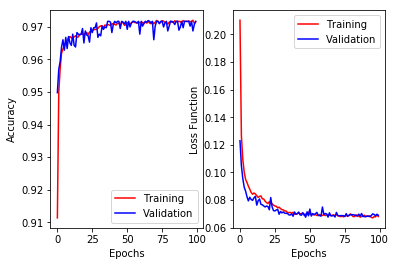

In [103]:
import keras.backend as K

if K.image_data_format() == 'channels_first':
    img_shape = (1,img_rows,img_cols)
elif K.image_data_format() == 'channels_last':
    img_shape = (img_rows,img_cols,1)

model_test = build_cnn_model(img_shape,nb_class)


model_test_history = model_test.fit(X_train,Y_train,batch_size=256,epochs=100,validation_split=0.05)
plot_history(model_test_history)
model_test.evaluate(X_test,Y_test,verbose=1)

In [104]:
###function for constructing a 3d cnn model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from keras.models import Model

def build_cnn3d_model(input_shape,out_shape,filters=32,convsize=3,poolsize=2,hidden_size=128):
    
#     import keras.backend as K
#     if K.image_data_format() == 'channels_first':
#         img_shape = (1,img_rows,img_cols)
#     elif K.image_data_format() == 'channels_last':
#         img_shape = (img_rows,img_cols,1)
    
    
    input0 = Input(shape=input_shape)
    conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(input0)
    conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling3D((poolsize,poolsize,poolsize))(conv1)
    drop1 = Dropout(0.25)(pool1)
    
    conv2 = Conv3D(filters*4,(convsize,convsize,convsize), padding='same',activation='relu')(drop1)
    conv2 = Conv3D(filters*4,(convsize,convsize,convsize),padding='same',activation='relu')(conv2)
    pool2 = MaxPooling3D((poolsize,poolsize,poolsize))(conv2)
    drop2 = Dropout(0.25)(pool2)
    
    flat = Flatten()(drop2)
    hidden = Dense(hidden_size,activation='relu')(flat)
    drop3 = Dropout(0.5)(hidden)
    out = Dense(out_shape,activation='softmax')(drop3)
    
    model = Model(inputs=input0,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

In [108]:
##prepare the data for 3d-cnn
#using each fmri volume as one sample
fmri_data_cnn = [];
label_data_cnn = [];
print(Subject_Num)
for subj in np.arange(Subject_Num):
    trial_mask = pd.Series(subjects_trial_label_matrix[subj]).isin(np.unique(list(task_contrasts.values()))) ##['hand', 'foot','tongue']
    '''
    import nibabel as nib
    fmri_file = nib.load(fmri_files[subj])
    fmri_img = fmri_file.get_data()
    print(fmri_img.shape)
    '''
    from nilearn.image import index_img
    fmri_img_trial = index_img(fmri_files[subj], np.where(trial_mask)[0])
    ###use each slice along z-axis as one sample
    fmri_data_trial = fmri_img_trial.get_data()
    label_data_trial = np.array(subjects_trial_label_matrix[subj])[trial_mask]

    fmri_data_cnn.append(fmri_data_trial)
    label_data_cnn.append(label_data_trial)

fmri_data_cnn = np.vstack(np.transpose(np.array(fmri_data_cnn),(0,4,1,2,3)))
label_data_cnn = np.vstack(label_data_cnn).reshape(Subject_Num*fmri_data_trial.shape[-1],)
print(fmri_data_cnn.shape,label_data_cnn.shape)

img_rows, img_cols, img_deps = fmri_img_trial.shape[:-1]
print(img_rows,img_cols, img_deps)

20
(1480, 61, 73, 61) (1480,)
61 73 61


In [109]:
##preprocess features and labels
from sklearn import preprocessing
X_data_scaled = np.expand_dims(np.float32(fmri_data_cnn)/np.max(fmri_data_cnn),4) #
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_data_int = le.transform(label_data_cnn)
Y_data_label = np_utils.to_categorical(Y_data_int)
nb_class = len(np.unique(list(task_contrasts.values())))

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data_scaled, Y_data_label,test_size=0.1, random_state=10)
print(X_train.shape,Y_train.shape,X_test.shape)
print('Samples for training: %d and testing %d with %d classes' % (X_train.shape[0],X_test.shape[0],nb_class))


(1332, 61, 73, 61, 1) (1332, 3) (148, 61, 73, 61, 1)
Samples for training: 1332 and testing 148 with 3 classes


In [112]:
import keras.backend as K

if K.image_data_format() == 'channels_first':
    img_shape_3d = (1,img_rows,img_cols,img_deps)
elif K.image_data_format() == 'channels_last':
    img_shape_3d = (img_rows,img_cols,img_deps, 1)

model_test_3d = build_cnn3d_model(img_shape_3d,nb_class)


model_test_3d_history = model_test_3d.fit(X_train,Y_train,batch_size=256,epochs=100,validation_split=0.05)
plot_history(model_test_3d_history)
model_test.evaluate(X_test,Y_test,verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 61, 73, 61, 1)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 61, 73, 61, 32)    896       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 61, 73, 61, 32)    27680     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 30, 36, 30, 32)    0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 36, 30, 32)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 30, 36, 30, 128)   110720    
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 30, 36, 30, 128)   442496    
__________

ResourceExhaustedError: OOM when allocating tensor with shape[256,32,61,73,61]
	 [[Node: conv3d_5/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_9_0_3/_903, conv3d_5/kernel/read)]]
	 [[Node: metrics_7/acc/Mean/_955 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1120_metrics_7/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv3d_5/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-56fd20a95a84>", line 8, in <module>
    model_test_3d = build_cnn3d_model(img_shape_3d,nb_class)
  File "<ipython-input-104-f4f8c11779a3>", line 15, in build_cnn3d_model
    conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(input0)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/keras/layers/convolutional.py", line 172, in call
    dilation_rate=self.dilation_rate)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3364, in conv3d
    data_format=tf_data_format)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 847, in conv3d
    padding=padding, data_format=data_format, name=name)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256,32,61,73,61]
	 [[Node: conv3d_5/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_9_0_3/_903, conv3d_5/kernel/read)]]
	 [[Node: metrics_7/acc/Mean/_955 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1120_metrics_7/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [111]:
''' expose different GPUs  if you are running multiple TensorFlow programs on the same machine,
Otherwise, TensorFlow will attempt to allocate almost the entire memory on all of the available GPUs,
which prevents other processes from using those GPU
'''
##to activate gpu tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES="0,1"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4312354596829434167
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 370999296
locality {
  bus_id: 1
}
incarnation: 17574607071879452272
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:05:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 182517760
locality {
  bus_id: 1
}
incarnation: 7421198862771188265
physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1"
]
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES="0,1"


In [113]:
###save the trained model
# serialize model to JSON
print("Saved 2d-cnn model to disk")
model_test_json = model_test.to_json()
with open("model_test_2dcnn.json", "w") as json_file:
    json_file.write(model_test_json)
# serialize weights to HDF5
model_test.save_weights("model_test_2dcnn.h5")

print("Saved 3d-cnn model to disk")
model_test_3d_json = model_test_3d.to_json()
with open("model_test_3dcnn.json", "w") as json_file:
    json_file.write(model_test_3d_json)
# serialize weights to HDF5
model_test_3d.save_weights("model_test_3dcnn.h5")

Saved 2d-cnn model to disk
Saved 3d-cnn model to disk
